/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  plt.draw()
/usr/local/lib/p

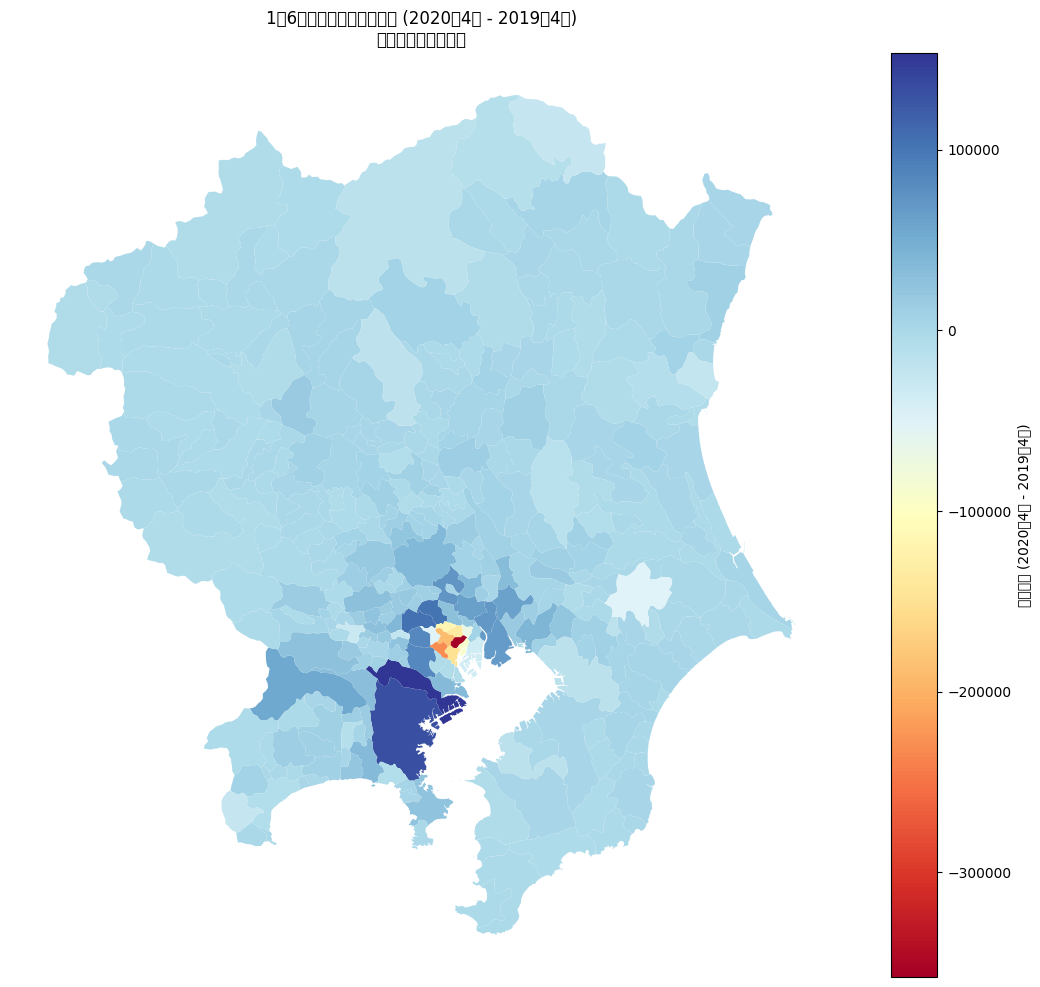


人口増加が最も大きい5市町村:
  prefecture      city  pop_diff
0   Kanagawa  Kawasaki  153458.0
1   Kanagawa  Yokohama  132798.0
2      Tokyo    Nerima  103857.0
3      Tokyo  Itabashi  102334.0
4      Tokyo  Setagaya   84714.0

人口減少が最も大きい5市町村:
    prefecture      city  pop_diff
325      Tokyo   Chiyoda -357824.0
324      Tokyo   Shibuya -231174.0
323      Tokyo  Shinjuku -189431.0
322      Tokyo    Minato -150033.0
321      Tokyo    Bunkyō -135708.0


In [3]:
# F2. 1都6県（東京、群馬、栃木、茨城、千葉、埼玉、神奈川）の市町村ごとの2019年4月の休日昼間人口と2020年4月の休日昼間人口の差を地図で示せ.

import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# データベース接続
engine = create_engine('postgresql://postgres:postgres@db:5432/gisdb')

# 2019年と2020年の人口データを取得するSQLクエリ
# F2の修正版
query = """
WITH pop_2019 AS (
    SELECT a.name_2, a.name_1,
           SUM(CASE 
               WHEN ST_Area(ST_Intersection(a.geom, p.geom)) / ST_Area(p.geom) > 0.5 
               THEN p.population 
               ELSE 0 
           END) as pop_2019
    FROM adm2 a
    JOIN pop201904 p ON ST_Intersects(a.geom, p.geom)
    WHERE a.name_1 IN ('Tokyo', 'Gunma', 'Tochigi', 'Ibaraki', 'Chiba', 'Saitama', 'Kanagawa')
    GROUP BY a.name_2, a.name_1
),
pop_2020 AS (
    SELECT a.name_2, a.name_1,
           SUM(CASE 
               WHEN ST_Area(ST_Intersection(a.geom, p.geom)) / ST_Area(p.geom) > 0.5 
               THEN p.population 
               ELSE 0 
           END) as pop_2020
    FROM adm2 a
    JOIN pop202004 p ON ST_Intersects(a.geom, p.geom)
    WHERE a.name_1 IN ('Tokyo', 'Gunma', 'Tochigi', 'Ibaraki', 'Chiba', 'Saitama', 'Kanagawa')
    GROUP BY a.name_2, a.name_1
)
SELECT 
    a.name_1 as prefecture,
    a.name_2 as city,
    a.geom,
    COALESCE(p2020.pop_2020, 0) - COALESCE(p2019.pop_2019, 0) as pop_diff
FROM adm2 a
LEFT JOIN pop_2019 p2019 ON a.name_2 = p2019.name_2 AND a.name_1 = p2019.name_1
LEFT JOIN pop_2020 p2020 ON a.name_2 = p2020.name_2 AND a.name_1 = p2020.name_1
WHERE a.name_1 IN ('Tokyo', 'Gunma', 'Tochigi', 'Ibaraki', 'Chiba', 'Saitama', 'Kanagawa')
ORDER BY pop_diff DESC;
"""

# クエリを実行してGeoDataFrameを作成
gdf = gpd.read_postgis(query, engine, geom_col='geom')

# 地図の作成
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
gdf.plot(column='pop_diff', 
        ax=ax,
        legend=True,
        legend_kwds={'label': '人口差分 (2020年4月 - 2019年4月)'},
        cmap='RdYlBu',
        missing_kwds={'color': 'lightgrey'})

# タイトルを追加
plt.title('1都6県の市町村別人口差分 (2020年4月 - 2019年4月)\n休日昼間人口の比較')

# 軸ラベルを非表示
ax.axis('off')

plt.show()

# 最も人口差が大きい/小さい上位5市町村を表示
print("\n人口増加が最も大きい5市町村:")
print(gdf.nlargest(5, 'pop_diff')[['prefecture', 'city', 'pop_diff']])
print("\n人口減少が最も大きい5市町村:")
print(gdf.nsmallest(5, 'pop_diff')[['prefecture', 'city', 'pop_diff']])